In [1]:
import numpy as np
import pandas as pd
from matplotlib import colors, pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm.autonotebook import tqdm, trange
from tqdm import tqdm_notebook


import torch
from torcheval.metrics.functional import multiclass_f1_score
from torchmetrics.classification import MulticlassAccuracy
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import datasets, models, transforms
import torch.optim as optim
from torch.optim import lr_scheduler
device = 'cuda' if torch.cuda.is_available() else 'cpu'

import PIL
from PIL import Image
import pickle
from skimage import io
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from multiprocessing.pool import ThreadPool
import time

/tmp/ipykernel_9767/388034765.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Stepik ID Даниил_Зелезецкий_175399976

In [2]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224

In [3]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files) #Принимает в себя файлы
        self.mode = mode # режим работы

        if self.mode not in DATA_MODES: #Проверка на то, корректно ли указан mode
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files) #Атрибут длины списка файлов(ака размер выборки)

        self.label_encoder = LabelEncoder() # Заводм LabelEncoder как метод класса

        if self.mode != 'test': # Если мы не в режиме val/train, то в labels записываем 
                    # названия папок(они называются как классы персонажей)
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)#Фитим энкодер на наших лейблах,но не меняем пока
            
            # сохраняем натренированый энкодер как label_encoder.pkl
            # 'wb' означает что мы записываем бинарные данные (???)
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file) 

    def __len__(self):
        return self.len_ #Метод, возвращающий атрибут длины

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(), #Превращает в тензор
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ]) #Нормализация по данным из ImageNet поканальная!
        x = self.load_sample(self.files[index]) #подгружает фотку по индексу
        x = self._prepare_sample(x) #Подгоняет фото под размер 224на224
        x = np.array(x / 255, dtype='float32') # зачем то делим на 225
        x = transform(x) # проводим те трансформации, кот. объявлены ранее
        if self.mode == 'test': #если мы в тестовом режиме, то просто возвращаем x без y
            return x
        else: #если мы в val,train режиме, то 
            label = self.labels[index] #берём лейбл по индексу
            label_id = self.label_encoder.transform([label]) #энкодим его в число
            y = label_id.item()
            return x, y #возвращаем связку объёкт-лейбл

    def _prepare_sample(self, image): #Подгоняет фото под размер 224на224
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [4]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [5]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('./train')
TEST_DIR = Path('./testset')

In [6]:
# формируем списки ссылок на фотки
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [7]:
from sklearn.model_selection import train_test_split
#array лейблов в train_val фотках
train_val_labels = [path.parent.name for path in train_val_files]
# Разбиваем train_val_files на отдельные train и val.Стратификация проходит по train_val_labels
# это по прежнему не тензоры, а просто списки ссылок(без лейблов,тк их вычленим к теле Класса)
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [8]:
#Делаем train и val датасеты, создавая классы, в теле которых уже будет происходить
# Нормализация,приведение в теннзорный вид, создание лейблов(числовых).
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')

In [9]:
print(f"Train dataset length: {len(train_dataset)}\nVal dataset length: {len(val_dataset)}")
print(f"Train dataset shape: {train_dataset[0][0].shape}\nVal dataset shape: {val_dataset[0][0].shape}")

Train dataset length: 15699
Val dataset length: 5234
Train dataset shape: torch.Size([3, 224, 224])
Val dataset shape: torch.Size([3, 224, 224])


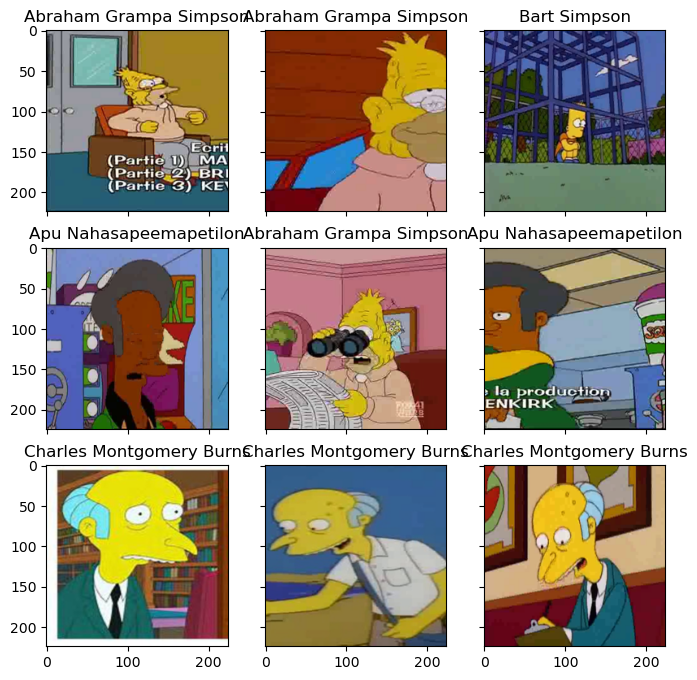

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [11]:
dataset_sizes = {'train':len(train_dataset), 'val':len(val_dataset)}

In [12]:
# Функция тренировки модели
def training(model, criterion, optimizer, scheduler, num_epochs, batch, losses, metrics, accs):
    
    # Создаём loader,в который засовывем классы.Далее при выплёвывании батча он будет 
    # обращаться к классу через _getitem_ и брать оттуда предобработанные тензоры с их лейблами
    dataloaders = {'train': torch.utils.data.DataLoader(train_dataset, batch_size=batch,
                                              shuffle=True, num_workers=2),
               'val': torch.utils.data.DataLoader(val_dataset, batch_size=batch,
                                              shuffle=True, num_workers=2)}
    
    since = time.time()
    best_model_wts = model.state_dict()
    best_f1 = 0
    best_acc = 0
    
    pbar = trange(num_epochs, desc="Epoch:")
    
    for epoch in pbar:
        for phase in ['train', 'val']:
            #=====Установка режима работы модели в зав-ти от фазы======
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.eval() 
            #======Обновление loss и целевых метрик =============
            running_loss = 0.0
            running_f1 = 0
            running_acc = 0
            #======Процесс итерации по батчам ===================
            for data in tqdm(dataloaders[phase], leave=False, desc=f"{phase} iter:"):
                
                batch_x, batch_y = data
                
                if device == 'cuda':
                    batch_x = batch_x.cuda()
                    batch_y = batch_y.cuda()
                else:
                    batch_x, batch_y = batch_x, batch_y
                    
                if phase == "train":
                    optimizer.zero_grad()
                
                if phase == "val":
                    with torch.no_grad():
                        output = model(batch_x)
                else :
                    output = model(batch_x)
                pred = torch.argmax(output, -1)
                loss = criterion(output, batch_y)#Loss считаем на сыром output.Softmax уже в лоссе
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                # статистика для фазы
                running_loss += loss.item()
                running_f1 += multiclass_f1_score(pred, batch_y, num_classes=42).tolist()
                running_acc += int(torch.sum(pred == batch_y.data))
            #Подсчёт усреднённых Loss и F1 для фазы и добавление данных в историю 
            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_f1 = running_f1 / len(dataloaders[phase])
            epoch_acc = running_acc / dataset_sizes[phase]
            losses[phase].append(epoch_loss)
            metrics[phase].append(epoch_f1)
            accs[phase].append(epoch_acc)
            
            pbar.set_description('{} Loss: {:.4f} F1: {:.4f} Acc: {:.4f}'.format(
                                    phase, epoch_loss, epoch_f1, epoch_acc
                                ))
            
            # если во время валидации на очередной эпохе словили наилучший усреднённый f1
            # то сохраним его в best_f1 и сохраняем веса этой модели в best_model_wts
            if phase == 'val' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_model_wts = model.state_dict()
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc  
    #=====Вывод технической информации о времени работы======
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
         time_elapsed // 60, time_elapsed % 60))
    print('Best val F!: {:4f}'.format(best_f1))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # загрузим лучшие веса модели
    #model.load_state_dict(best_model_wts)
    return model, losses, metrics, accs, best_model_wts

In [13]:
# Функция визуализации работы модели
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images // 2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [14]:
# Оценка качества модели на val сете
def evaluate(model,batch):
    
    # Создаём loader,в который засовывем классы.Далее при выплёвывании батча он будет 
    # обращаться к классу через _getitem_ и брать оттуда предобработанные тензоры с их лейблами
    dataloaders = {'val': torch.utils.data.DataLoader(val_dataset, batch_size=batch,
                                              shuffle=True, num_workers=2)}    
    model.eval()
    
    runninig_f1 = 0
    for data in dataloaders['val']:
        
        batch_x, batch_y = data
        
        if device == 'cuda' :
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            
        # forard pass
        output = model(batch_x)
        pred = torch.argmax(output, -1)
        
        runninig_f1 += multiclass_f1_score(pred, batch_y, num_classes=42).tolist()
        
    return runninig_f1 / len(dataloaders['val'])

# Дообучение ResNet152

In [15]:
model = models.resnet152(weights=None)
model.fc = nn.Linear(in_features=2048, out_features=42, bias=True)
model = model.to(device)

# Обучение производилось в другом ноутбуке
    В целях экономии времени проверяющего, процесс дообучения
        я решил не включать в чистовой вариант работы.
        В описании к ноутбуку на степике лежит ссылка на 
        файл с весами модели.
    Мною была скачана предобученная на IMAGENET модель ResNet152, 
    которую я дополнительно доучивал под свои данные в течение 22 эпох.
    Вместе с данным ноутбуком, я прикрепляю файл с весами модели
    на случай, если появится необходимость запустить модель локально.

In [16]:
model.load_state_dict(torch.load('ResNet152_pretrained(F1~99%).pth'))

<All keys matched successfully>

In [17]:
test_dataset = SimpsonsDataset(test_files, mode="test")
dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=30,
                                             shuffle=False, num_workers=2)
test_filenames = [path.name for path in test_dataset.files]
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [18]:
def predict(model,batch):
    predictions = np.array([])
    dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch,
                                              shuffle=False, num_workers=2)    
    model.eval()
    for data in dataloader:
        
        batch_x = data
        
        if device == 'cuda' :
            batch_x = batch_x.cuda()
            

        output = model(batch_x)
        pred = torch.argmax(output, -1)
        predictions = np.concatenate( (predictions, pred.cpu().numpy()) )
    return predictions

In [19]:
predictions = predict(model, 30)
predictions = label_encoder.inverse_transform( np.array([int(i) for i in predictions]) )

In [20]:
total_df = pd.DataFrame({'Id':pd.Series(test_filenames), 'Expected':pd.Series(predictions)})

In [21]:
total_df.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [22]:
total_df.to_csv('Final_Kaggle_result.csv', index=False)

# Stepik ID Даниил_Зелезецкий_175399976

![alt text](https://s1.hostingkartinok.com/uploads/images/2023/11/80ea480c83aa2df181abb1425d12ec31.jpg)
